In [1]:
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from numba import jit
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import root_scalar, curve_fit
from pynndescent import NNDescent
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
# from umap import UMAP
# from umap.parametric_umap import ParametricUMAP
# from umap.spectral import spectral_layout

In [2]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

In [3]:
mnist = MNIST(
    './data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

In [4]:
testdata = mnist.data.reshape(-1, 28*28) / 255.
testdata = testdata[:5000]

In [5]:
@jit
def entropy(d, beta):
    x = - d * beta
    y = np.exp(x)
    ysum = y.sum()
    if ysum < 1e-50:
        return -1.
    else:
        factor = - 1/(np.log(2.) * ysum)
        return factor * ((y * x) - (y * np.log(ysum))).sum()
    
def p_i(d, beta):
    x = - d * beta
    y = np.exp(x)
    ysum = y.sum()
    return y / ysum

def find_beta(d, perp, upper_bound=1e6):
    return root_scalar(
        lambda b: entropy(d, b) - np.log2(perp),
        bracket=(0.,upper_bound)
    ).root

In [6]:
def p_ij_sym(x, perp, verbose=False):
    num_pts = x.shape[0]
    k = min(num_pts - 1, int(3 * perp))
    if verbose:
        print('Indexing')
    index = NNDescent(x, n_neighbors=k)
    neighbors = np.empty((num_pts, k-1), dtype=np.int)
    p_ij = np.empty((num_pts, k-1))
    for i, xi in enumerate(x):
        if verbose:
            print('Calculating probabilities: {cur}/{tot}'.format(
                cur=i+1, tot=num_pts), end='\r')
        nn, dists = index.query([xi], k)
        beta = find_beta(dists[0, 1:], perp)
        neighbors[i] = nn[0, 1:]
        p_ij[i] = p_i(dists[0, 1:], beta)
    row_indices = np.repeat(np.arange(num_pts), k-1)
    p = csr_matrix((p_ij.ravel(), (row_indices, neighbors.ravel())))
    return 0.5*(p + p.transpose())

In [13]:
p_ij_sym(testdata.numpy(), 200, verbose=True)

Indexing


<5000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 4263182 stored elements in Compressed Sparse Row format>

In [7]:
def p_ij_sym_noquery(x, perp, verbose=False):
    num_pts = x.shape[0]
    k = min(num_pts - 1, int(3 * perp))
    if verbose:
        print('Indexing')
    index = NNDescent(x, n_neighbors=k)
    neighbors, p_ij = index.neighbor_graph
    neighbors = neighbors[:,1:]
    p_ij = p_ij[:,1:]
    # neighbors = np.empty((num_pts, k-1), dtype=np.int)
    # p_ij = np.empty((num_pts, k-1))
    for i, xi in enumerate(x):
        if verbose:
            print('Calculating probabilities: {cur}/{tot}'.format(
                cur=i+1, tot=num_pts), end='\r')
        beta = find_beta(p_ij[i], perp)
        p_ij[i] = p_i(p_ij[i], beta)
    row_indices = np.repeat(np.arange(num_pts), k-1)
    p = csr_matrix((p_ij.ravel(), (row_indices, neighbors.ravel())))
    return 0.5*(p + p.transpose())

In [8]:
p_ij_sym_noquery(testdata.numpy(), 200, verbose=True)

Indexing


<5000x5000 sparse matrix of type '<class 'numpy.float32'>'
	with 4262972 stored elements in Compressed Sparse Row format>

In [17]:
index = NNDescent(testdata, n_neighbors=500)

In [18]:
nn, dist = index.neighbor_graph

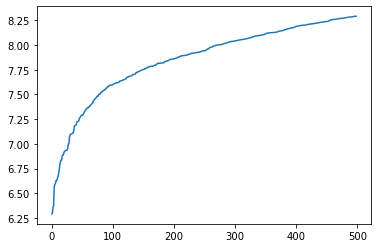

In [26]:
plt.plot(dist[500,1:])

In [27]:
foo = nn[0]

In [37]:
distmat = csr_matrix((
    dist.flatten(),
    (np.repeat(np.arange(nn.shape[0]), nn.shape[1]), nn.flatten())
))

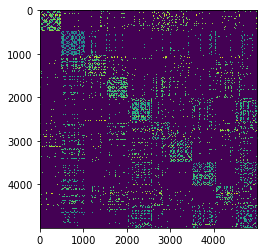

In [43]:
plt.imshow(distmat[np.argsort(mnist.targets[:5000])][:,np.argsort(mnist.targets[:5000])].toarray())

In [46]:
from typing import Union, Optional
import warnings

In [ ]:
class PairwiseRelationship():

    def __init__(
        self,
        neighborhood_based: bool = False,
        n_neighbors: Optional[int] = None,
        verbose: bool = False
    ):

        self.distance_matrix = None
        self.scales = None
        self.transform_function = None
        self.neighborhood_based = neighborhood_based
        self.n_neighbors = n_neighbors
        self.verbose = verbose

    def calculate_distmat(
        self,
        X: Union[np.array, torch.Tensor]
    ):

        if self.verbose:
            print(f"{datetime.now()}: Calculating distance matrix.")

        if self.neighborhood_based:
            index = NNDescent(X, self.n_neighbors)
            neighbors, distances = index.neighbor_graph
            self.distance_matrix = csr_matrix((
                distances.flatten(), (
                    np.repeat(
                        np.arange(X.shape[0]),
                        self.n_neighbors
                    ),
                    neighbors.flatten()
                )
            ))
        else:
            self.distance_matrix = squareform(
                pdist(X)
            )

In [ ]:
def p_ij_sym_noquery(x, perp, verbose=False):
    num_pts = x.shape[0]
    k = min(num_pts - 1, int(3 * perp))
    if verbose:
        print('Indexing')
    index = NNDescent(x, n_neighbors=k)
    neighbors, p_ij = index.neighbor_graph
    neighbors = neighbors[:,1:]
    p_ij = p_ij[:,1:]
    # neighbors = np.empty((num_pts, k-1), dtype=np.int)
    # p_ij = np.empty((num_pts, k-1))
    for i, xi in enumerate(x):
        if verbose:
            print('Calculating probabilities: {cur}/{tot}'.format(
                cur=i+1, tot=num_pts), end='\r')
        beta = find_beta(p_ij[i], perp)
        p_ij[i] = p_i(p_ij[i], beta)
    row_indices = np.repeat(np.arange(num_pts), k-1)
    p = csr_matrix((p_ij.ravel(), (row_indices, neighbors.ravel())))
    return 0.5*(p + p.transpose())